<a href="https://colab.research.google.com/github/spkibe/cnn_lung_cancer_classification/blob/main/Chest_cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **import library**

In [4]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

**This code finds pictures of brains with and without tumors in a special folder. It looks inside each folder to find the pictures and labels them as either "yes" (tumor) or "no" (no tumor). Then it organizes all this information into a list that shows which picture belongs to which label.**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Directory containing the "brain_tumor_dataset" folder
directory = "/content/drive/MyDrive/archive/new_data/train"

# Collect file paths and labels from subfolders
filepaths = []
labels = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepaths.append(img_path)
        labels.append(fold)

# Create DataFrame from collected data
file_path_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)

In [12]:
# Head
df_train.head(10)

,filepath,label
0,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
1,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
2,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
3,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
4,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
5,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
6,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
7,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
8,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma
9,/content/drive/MyDrive/archive/new_data/train/...,Carcinoma


# **Data Spliting**


**This code splits a dataset (df_train) into three subsets: train_df (80% for training), valid_df (10% for validation), and test_df (10% for testing), ensuring random shuffling and reproducibility with a fixed random seed (42). It prepares the data for training a machine learning model while ensuring separate datasets for validation and final evaluation.**

In [13]:
#یہ کوڈ ایک ڈیٹا سیٹ کو تین حصوں میں تقسیم کرتا ہے: تربیت کے لیے 80%، تصدیق کے لیے 10%، اور آخری ارزیابی کے لیے 10%، مختلف ڈیٹا سیٹس کو تیار کرتا ہے۔
from sklearn.model_selection import train_test_split

# Spliting in Train and Dummy
train_df , dummy_df = train_test_split(df_train ,train_size = 0.8 , shuffle = True ,random_state = 42 )
# Spliting in Validation and Test From Dummy
valid_df , test_df = train_test_split(dummy_df ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [14]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {valid_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (452, 2)
The shape of The Validation data is: (57, 2)
The shape of The Test data is: (57, 2)


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**This code prepares image data for training a model. It uses ImageDataGenerator to create generators for training, validation, and test datasets. Augmentation techniques like shearing, zooming, and flipping are applied to the training data (train_datagen), while validation and test data (validation_test_datagen) are only rescaled. Each dataset (train_ds, validation_ds, test_ds) is loaded from a DataFrame (train_df, valid_df, test_df) containing file paths and labels, resized to 256x256 pixels, batched into groups of 12 images, and set for binary classification mode.**

In [16]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Training data generator with augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # Validation and test data generator without augmentation
# validation_test_datagen = ImageDataGenerator(rescale=1./255)

# # Define batch size
# batch_size = 32


# # Flow from dataframe or directory, ensuring binary class_mode
# print("Training Data")
# train_ds = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='filepath',
#     y_col='label',
#     target_size=(229, 229),
#     batch_size=32,
#     class_mode='binary'
# )

# print("Validation Data")
# validation_ds = validation_test_datagen.flow_from_dataframe(
#     dataframe=valid_df,
#     x_col='filepath',
#     y_col='label',
#     target_size=(229, 229),
#     batch_size=32,
#     class_mode='binary'
# )

# print("Test Data")
# test_ds = validation_test_datagen.flow_from_dataframe(
#     dataframe=test_df,
#     x_col='filepath',
#     y_col='label',
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

Training Data
Found 452 validated image filenames belonging to 2 classes.
Validation Data
Found 57 validated image filenames belonging to 2 classes.
Test Data
Found 57 validated image filenames belonging to 2 classes.


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Flow from dataframe or directory, ensuring binary class_mode
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(299, 299),  # Updated target size for Xception
    batch_size=batch_size,
    class_mode='binary'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(299, 299),  # Updated target size for Xception
    batch_size=batch_size,
    class_mode='binary'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(299, 299),  # Updated target size for Xception
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Training Data
Found 452 validated image filenames belonging to 2 classes.
Validation Data
Found 57 validated image filenames belonging to 2 classes.
Test Data
Found 57 validated image filenames belonging to 2 classes.


In [31]:
# Test the training data generator
print("Testing Training Data Generator")
x_train, y_train = next(iter(train_ds))
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Test the validation data generator
print("Testing Validation Data Generator")
x_valid, y_valid = next(iter(validation_ds))
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")


Testing Training Data Generator
x_train shape: (32, 299, 299, 3)
y_train shape: (32,)
Testing Validation Data Generator
x_valid shape: (32, 299, 299, 3)
y_valid shape: (32,)


**This code counts and visualizes the distribution of categories in the 'label' column of the DataFrame df_train. It creates two subplots: one with a pie chart showing the percentage distribution of each category, and another with a bar chart displaying the count of each category.**

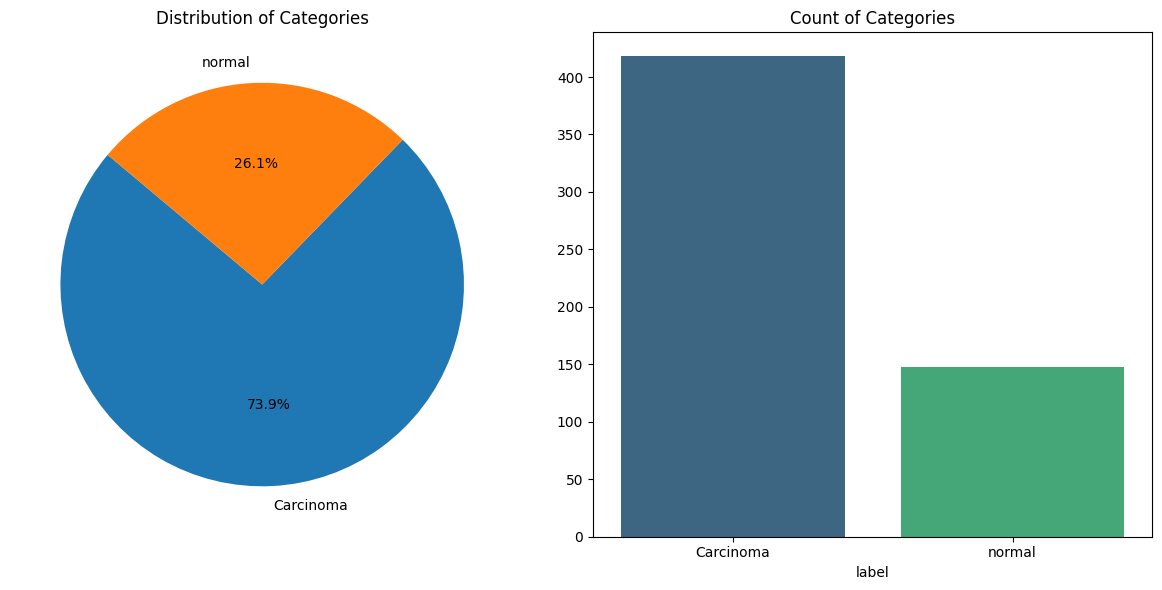

In [18]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

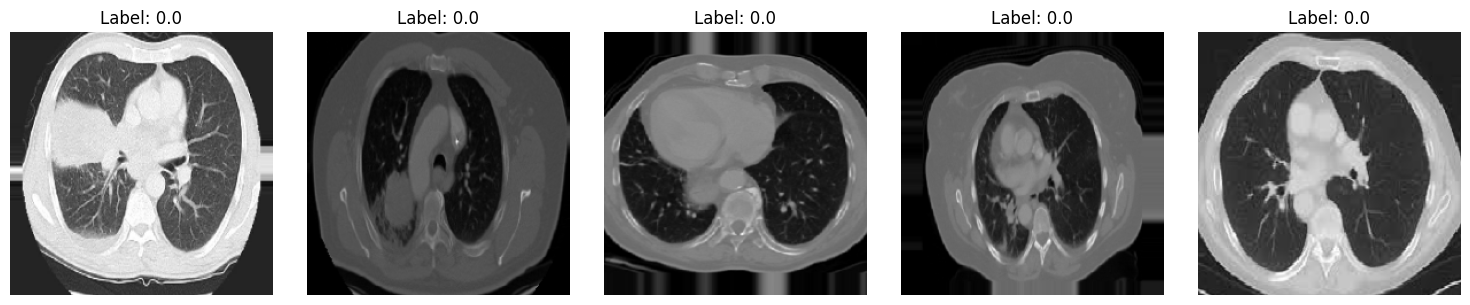

In [19]:
# Function to select and display random images
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 5)


In [21]:
# Define the class labels for brain tumor classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')


Class labels: {'Carcinoma': 0, 'normal': 1}


# **IMPORT PRETRAIED MODEL**

In [22]:
from tensorflow.keras.applications import Xception

# **transfer-learning**

**ResNet50 pre-trained on ImageNet, excluding the top classification layer, with an input shape of 256x256 pixels and 3 channels (RGB).**

In [23]:
# Load the Xception model as the base model with pre-trained weights
conv_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# **Define Architecture**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input

# Load the Xception model as the base model with pre-trained weights
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Define the input shape for the model
input_shape = (299, 299, 3)  # Updated input shape to match the image size for Xception

# Build the Sequential model
model = Sequential([
    Input(shape=input_shape),  # Add the Input layer
    conv_base,  # Add the base Xception model
    GlobalAveragePooling2D(),  # Add Global Average Pooling to flatten the output from the base model
    BatchNormalization(),  # Batch Normalization
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Dense Layer 1
    BatchNormalization(),  # Batch Normalization
    Dropout(0.5),  # Dropout Layer
    Dense(1, activation='sigmoid')  # Output Layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,395,497 (81.62 MB)

 Trainable params: 21,336,361 (81.39 MB)

 Non-trainable params: 59,136 (231.00 KB)

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# history = model.fit(train_ds,epochs=50,batch_size=32,validation_data=validation_ds)

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Defining a Checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/save_model/C_CT_S.keras',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Defining Early Stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,  # Stop if improvement is smaller than 0.01
                          patience=5,  # Wait for 5 epochs before stopping
                          restore_best_weights=True)

# Defining Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,  # Reduce learning rate by a factor of 0.1
                              patience=3,  # Wait for 3 epochs before reducing
                              verbose=1,
                              min_delta=0.01)  # Stop reducing if improvement is smaller than 0.01

# Callback list
callbacks = [checkpoint, earlystop, reduce_lr]

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    epochs=12,  # Limiting to 12 epochs
    validation_data=validation_ds,
    callbacks=callbacks
)

Epoch 1/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9793 - loss: 0.2299
Epoch 1: val_accuracy improved from -inf to 0.89474, saving model to /content/drive/MyDrive/save_model/C_CT_S.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9784 - loss: 0.2330 - val_accuracy: 0.8947 - val_loss: 2.3998 - learning_rate: 0.0010
Epoch 2/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9766 - loss: 0.1548
Epoch 2: val_accuracy did not improve from 0.89474
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 868ms/step - accuracy: 0.9762 - loss: 0.1552 - val_accuracy: 0.8246 - val_loss: 1.1735 - learning_rate: 0.0010
Epoch 3/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.9854 - loss: 0.1356
Epoch 3: val_accuracy did not improve from 0.89474
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 989ms/step - accuracy: 0.9852 - loss: 0.1362 - val_accuracy: 0.4912 - val_loss: 4.7596 - learning_rate: 0.0010
Epoch 4/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.9805 - loss: 0.1093
Epoch 4: val_accur

In [39]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 1.0000 - loss: 0.0669
Test accuracy: 1.0


In [40]:
# from tensorflow.keras.models import load_model
# from sklearn.metrics import classification_report, confusion_matrix

# # Load the saved model
# model = load_model('/content/drive/MyDrive/save_model/C_CT_S.keras')

# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(test_ds)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# print(f"Test Loss: {test_loss:.4f}")

# # Predict on test data
# y_pred = model.predict(test_ds)
# y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert predictions to binary (0 or 1)

# # Get true labels
# y_true = test_ds.classes

# # Classification Report
# print("Classification Report:")
# print(classification_report(y_true, y_pred_classes))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_true, y_pred_classes))

ValueError: Layer "batch_normalization_14" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_683>, <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_684>]

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input

# Rebuild the model architecture
conv_base = Xception(weights=None, include_top=False, input_shape=(299, 299, 3))  # Set weights=None

model = Sequential([
    Input(shape=(299, 299, 3)),
    conv_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Load the saved weights
model.load_weights('/content/drive/MyDrive/save_model/C_CT_S.keras')

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9883 - loss: 0.0821
Test Accuracy: 98.25%
Test Loss: 0.0936


In [43]:
pred = model.predict(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


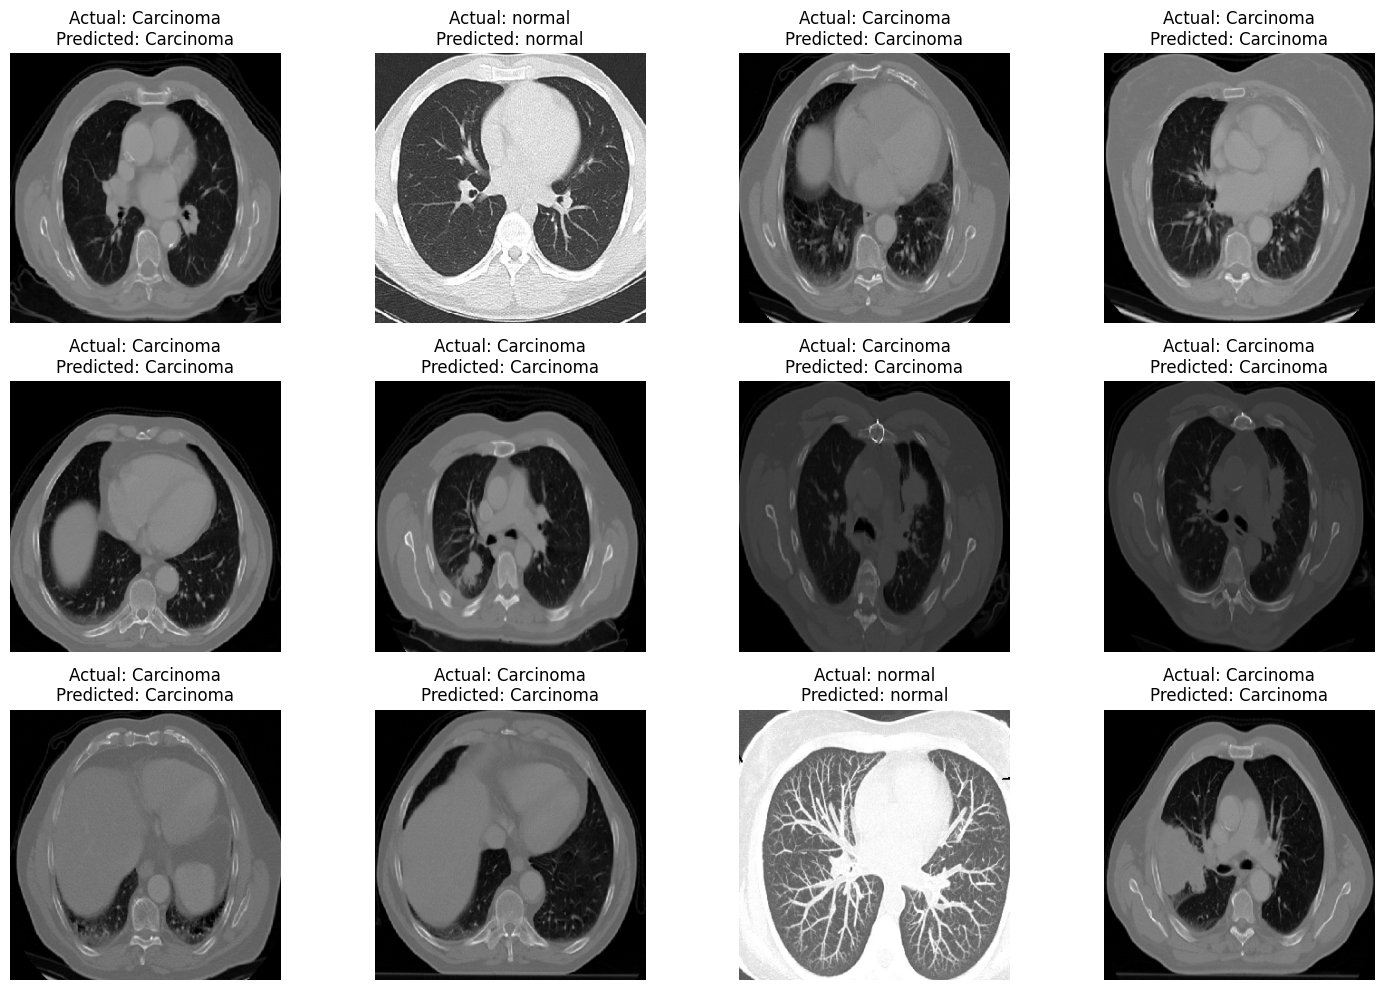

In [44]:
# Fetch a batch of test data from the test dataset generator (test_ds)
x_test, y_test = next(iter(test_ds))
num_images_to_display = 12  # Number of images to display
x_test = x_test[:num_images_to_display]  # Limit to the number of images to display
y_test = y_test[:num_images_to_display]  # Limit to the number of images to display

# Get predictions for the batch of test images
pred = model.predict(x_test)
pred = (pred > 0.5).astype(int).reshape(-1)

# Define class names
classes = ['Carcinoma', 'normal']

# Number of columns for the subplot grid
num_columns = 4

# Number of rows calculated based on the number of images and columns
num_rows = (num_images_to_display + num_columns - 1) // num_columns

# Plot the images with actual and predicted labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        actual_label = classes[int(y_test[i])]  # Convert y_test to int index
        predicted_label = classes[pred[i]]  # Use pred directly as it's already converted
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# **Plotting the Graph**

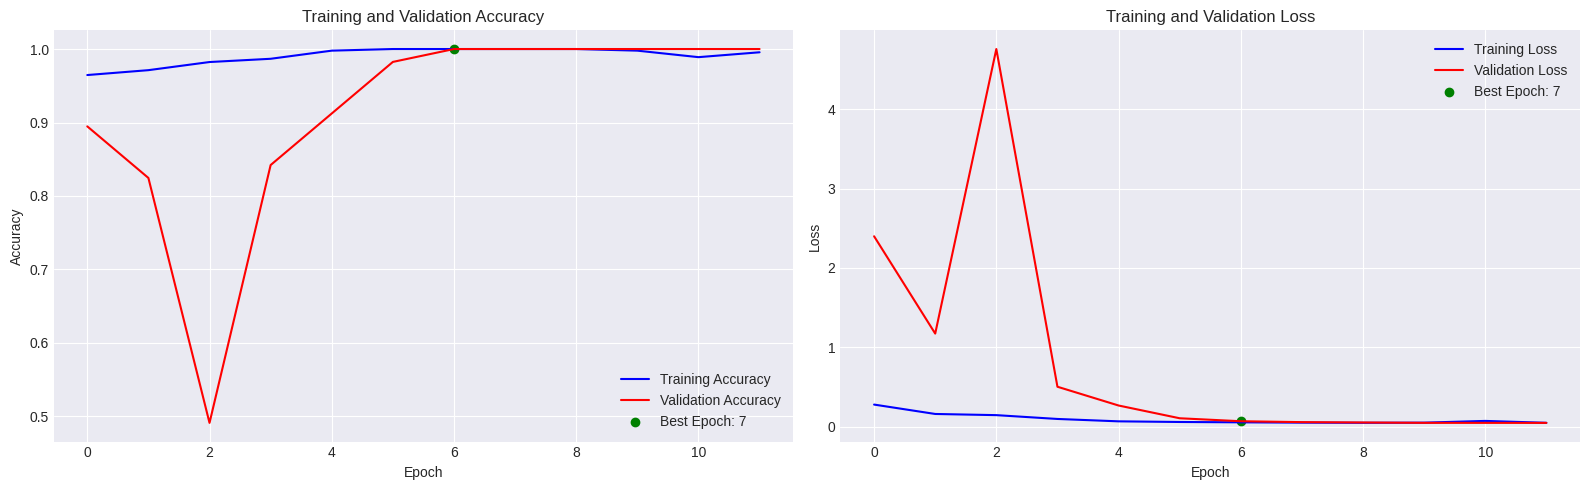

In [45]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()